In [25]:
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/lib')

# Set random seeds for reproducibility
torch.manual_seed(42)

# Configuration - base directory
base_dir = Path("/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/p_scan_erf_kappa0.07/d150_P800_N1600_chi50_kappa0.07")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Find all seed directories
seed_dirs = sorted([d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('seed')])
print(f"Found {len(seed_dirs)} seed directories: {[d.name for d in seed_dirs]}")

# Load config from first seed (should be same for all seeds)
with open(seed_dirs[0] / "config.json") as f:
    config = json.load(f)

print("Configuration:", config)
d = config['d']
P = config['P']
N = config['N']
chi = config['chi']
kappa = config.get('kappa', 0.07)
print(f"Parameters: d={d}, P={P}, N={N}, chi={chi}, kappa={kappa}")
print(f"Will average predictions over {len(seed_dirs)} seeds")


Found 5 seed directories: ['seed1', 'seed2', 'seed3', 'seed4', 'seed5']
Configuration: {'d': 150, 'P': 800, 'N': 1600, 'kappa': 0.07, 'lr': 1.25e-05, 'epochs': 10000000, 'chi': 50, 'seed': 1, 'ens': 5, 'current_epoch': 3000000}
Parameters: d=150, P=800, N=1600, chi=50, kappa=0.07
Will average predictions over 5 seeds


In [26]:
# Load h3 projections (contains eigenvalues and projections)
# We'll load from all seeds and average the eigenvalues
import json
import numpy as np

all_h3_data = []
for seed_dir in seed_dirs:
    with open(seed_dir / "h3_projections_fcn3.json") as f:
        all_h3_data.append(json.load(f))

# Average eigenvalues across all seeds
lH1T_list = [float(data['h1']['target']['second_moment']) for data in all_h3_data]
lH1P_list = [float(data['h1']['perp']['second_moment']) for data in all_h3_data]
lH3T_list = [float(data['h3']['target']['second_moment']) for data in all_h3_data]
lH3P_list = [float(data['h3']['perp']['second_moment']) for data in all_h3_data]

lH1T = np.mean(lH1T_list)
lH1P = np.mean(lH1P_list)
lH3T = np.mean(lH3T_list)
lH3P = np.mean(lH3P_list)

print(f"Averaged eigenvalues over {len(seed_dirs)} seeds:")
print(f"H1 target eigenvalue (lH1T): {lH1T:.6e} ± {np.std(lH1T_list):.6e}")
print(f"H1 perp eigenvalue (lH1P): {lH1P:.6e} ± {np.std(lH1P_list):.6e}")
print(f"H3 target eigenvalue (lH3T): {lH3T:.6e} ± {np.std(lH3T_list):.6e}")
print(f"H3 perp eigenvalue (lH3P): {lH3P:.6e} ± {np.std(lH3P_list):.6e}")


Averaged eigenvalues over 5 seeds:
H1 target eigenvalue (lH1T): 2.031751e-02 ± 4.386596e-04
H1 perp eigenvalue (lH1P): 2.834271e-03 ± 1.825884e-05
H3 target eigenvalue (lH3T): 3.687400e-06 ± 8.146592e-07
H3 perp eigenvalue (lH3P): 2.161143e-07 ± 3.332130e-08


In [27]:
from FCN3Network import FCN3NetworkActivationGeneric

# Create and load models from all seeds
models = []
for seed_dir in seed_dirs:
    model = FCN3NetworkActivationGeneric(
        d=d,
        n1=N,
        n2=N,
        P=P,
        ens=config['ens'],
    ).to(device)
    
    # Load the state dict
    state_dict = torch.load(seed_dir / "model.pt", map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    models.append(model)
    print(f"Loaded model from {seed_dir.name}")

print(f"\nTotal models loaded: {len(models)}")
print(f"Model type: {type(models[0])}")
print(f"Ensemble size per model: {models[0].ens}, n1={models[0].n1}, n2={models[0].n2}")


Loaded model from seed1
Loaded model from seed2
Loaded model from seed3
Loaded model from seed4
Loaded model from seed5

Total models loaded: 5
Model type: <class 'FCN3Network.FCN3NetworkActivationGeneric'>
Ensemble size per model: 5, n1=1600, n2=1600


In [37]:
# Generate large test set
n_test = 10000
X_test = torch.randn(n_test, d, dtype=torch.float32, device=device)

# Normalize X_test to unit norm (typical for high-dimensional input)
X_test = X_test / torch.norm(X_test, dim=1, keepdim=True)

print(f"Generated test set X_test with shape {X_test.shape}")

# Define true target function: He1 + 0.03/sqrt(6) * He3
# He1(x) = x (linear component of Hermite polynomial)
# He3(x) = x^3 - 3*x (probabilist's Hermite polynomial)

def true_function(X):
    """Compute target = He1(x) + 0.03/sqrt(6) * He3(x)"""
    # He1 component: dot product with first feature direction
    he1_part = X[:, 0]  # Just the first coordinate
    
    # He3 component: x^3 - 3*x 
    he3_part = X[:, 0]**3 - 3*X[:, 0]
    
    # Combine with weights
    target = he1_part + 0.03* he3_part
    return target

y_true = true_function(X_test)
print(f"True function evaluated on test set, shape: {y_true.shape}")
print(f"True function range: [{y_true.min():.4f}, {y_true.max():.4f}]")

Generated test set X_test with shape torch.Size([10000, 150])
True function evaluated on test set, shape: torch.Size([10000])
True function range: [-0.2766, 0.2763]


In [38]:
# Check structure of h3_projections to understand what data we have (using first seed as example)
h3_data = all_h3_data[0]
print("H1 target keys:", list(h3_data['h1']['target'].keys()))
print("H1 perp keys:", list(h3_data['h1']['perp'].keys()))
print("H3 target keys:", list(h3_data['h3']['target'].keys()))
print("H3 perp keys:", list(h3_data['h3']['perp'].keys()))

# Check if we have projection coefficients y_k
# The projections should store projections of the Hermite basis onto kernel eigenvectors
if 'projections' in h3_data['h1']['target']:
    print(f"H1 target projections shape: {torch.tensor(h3_data['h1']['target']['projections']).shape}")
if 'projections' in h3_data['h3']['target']:
    print(f"H3 target projections shape: {torch.tensor(h3_data['h3']['target']['projections']).shape}")


H1 target keys: ['mean', 'std', 'var', 'second_moment', 'ens_mean', 'ens_std', 'ens_sem']
H1 perp keys: ['mean', 'std', 'var', 'second_moment', 'ens_mean', 'ens_std', 'ens_sem']
H3 target keys: ['mean', 'std', 'var', 'second_moment', 'ens_mean', 'ens_std', 'ens_sem']
H3 perp keys: ['mean', 'std', 'var', 'second_moment', 'ens_mean', 'ens_std', 'ens_sem']


In [39]:
# Test first model output shape
models[0](X_test).shape


torch.Size([10000, 5])

Computing predictions from all seeds...
Seed 1: predictions range [-0.5762, 0.5540]
Seed 2: predictions range [-0.5619, 0.5449]
Seed 3: predictions range [-0.5534, 0.5446]
Seed 4: predictions range [-0.5612, 0.5490]
Seed 5: predictions range [-0.5553, 0.5561]

Averaged model predictions shape: torch.Size([10000])
Averaged model predictions range: [-0.5616, 0.5497]

Ridge regression weights:
Effective ridge parameter: 8.750000e-05
H1T weight: 0.995712 (eigenvalue: 2.031751e-02)
H3T weight: 0.040438 (eigenvalue: 3.687400e-06)
EK predictions shape: torch.Size([10000])
EK predictions range: [-0.3007, 0.3004]
EK linear component range: [-0.3017, 0.3014]
EK cubic component range: [-0.0011, 0.0011]


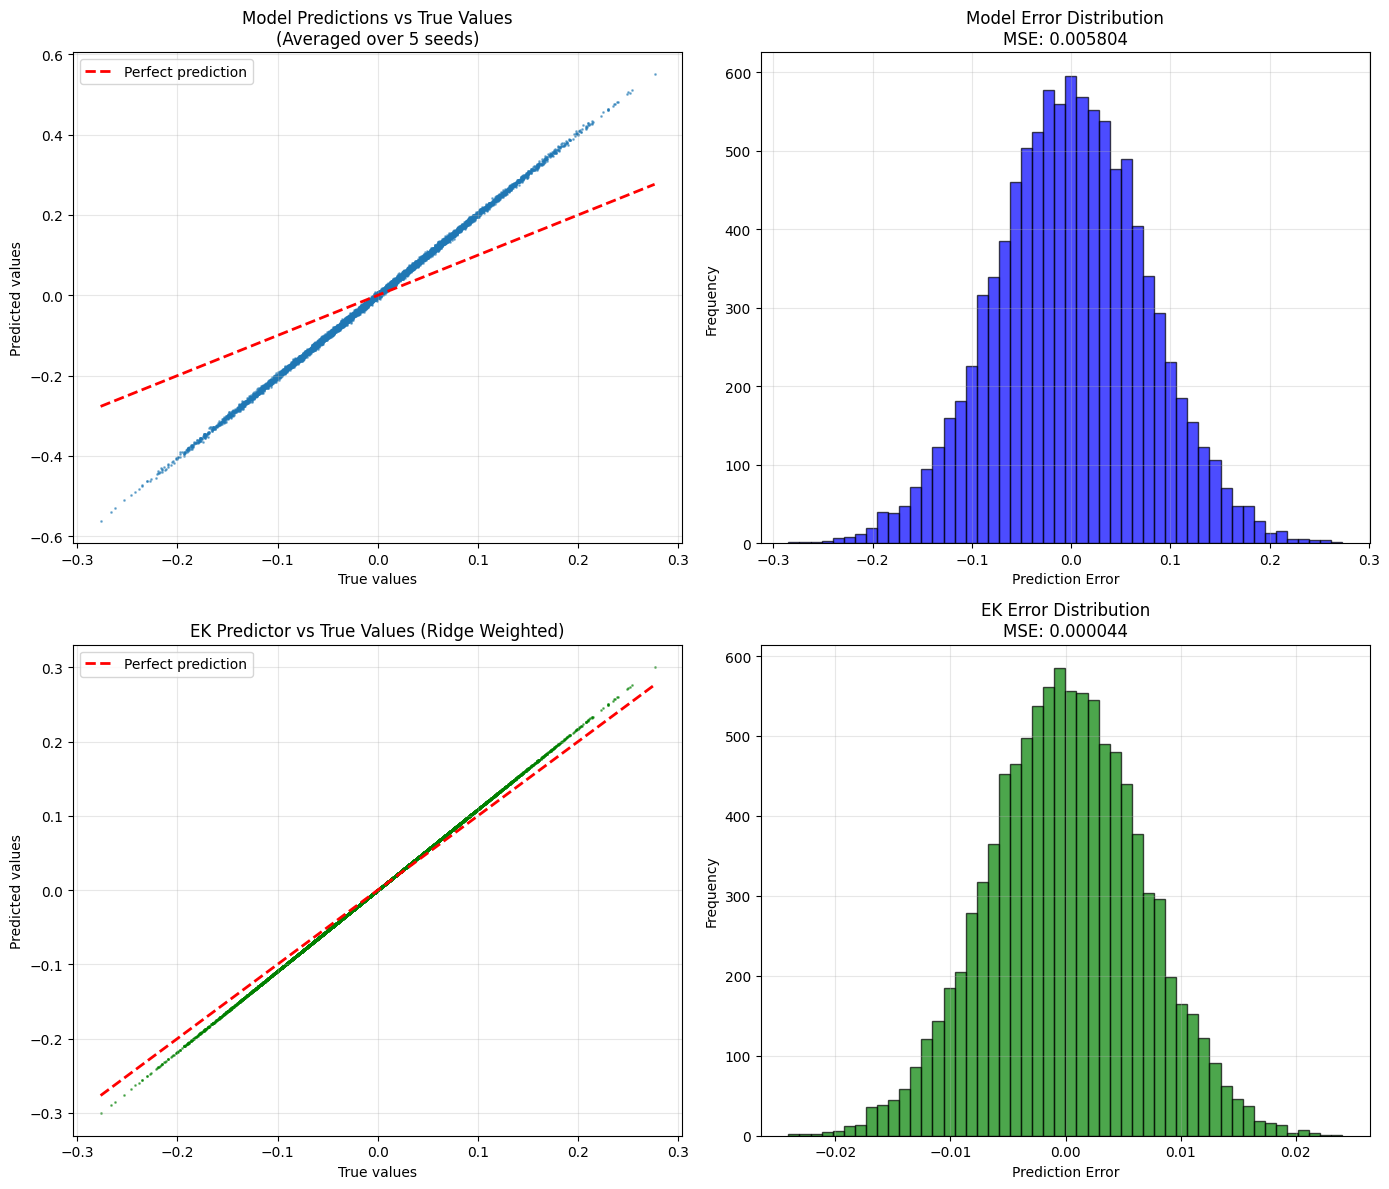


Model Performance (averaged over 5 seeds):
MSE: 5.804345e-03
MAE: 6.070110e-02

EK Predictor Performance:
MSE: 4.442920e-05
MAE: 5.324288e-03

Comparison:
MSE Ratio (EK/Model): 0.0077
MAE Ratio (EK/Model): 0.0877


In [40]:
# Compute model predictions averaged over all seeds
print("Computing predictions from all seeds...")
all_predictions = []
for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).mean(axis=1).squeeze()  # Average over ensemble and remove extra dim
        all_predictions.append(y_pred)
        print(f"Seed {i+1}: predictions range [{y_pred.min():.4f}, {y_pred.max():.4f}]")

# Average predictions across all seeds
y_pred_model = torch.stack(all_predictions).mean(dim=0)

print(f"\nAveraged model predictions shape: {y_pred_model.shape}")
print(f"Averaged model predictions range: [{y_pred_model.min():.4f}, {y_pred_model.max():.4f}]")

# Compute EK predictor using eigenvalues with ridge regression formula
# The EK predictor uses: weight_k = lambda_k / (lambda_k + kappa_eff / P)
X = X_test  # Use test data
he1_part = X[:, 0]  # He1 component (linear)
he3_part = X[:, 0]**3 - 3*X[:, 0]  # He3 component (cubic)

# Compute effective ridge parameter and weights
effective_ridge = kappa / 800
weight_H1T = lH1T / (lH1T + effective_ridge)
weight_H3T = lH3T / (lH3T + effective_ridge)

print(f"\nRidge regression weights:")
print(f"Effective ridge parameter: {effective_ridge:.6e}")
print(f"H1T weight: {weight_H1T:.6f} (eigenvalue: {lH1T:.6e})")
print(f"H3T weight: {weight_H3T:.6f} (eigenvalue: {lH3T:.6e})")

# Combine with ridge-weighted eigenvalues
# Need to also account for the true function coefficients
true_coef_H1 = 1.0
true_coef_H3 = 0.03 

# Compute linear and cubic components separately
y_pred_ek_linear = weight_H1T * true_coef_H1 * he1_part
y_pred_ek_cubic = weight_H3T * true_coef_H3 * he3_part
y_pred_ek = y_pred_ek_linear + y_pred_ek_cubic

# True function components
y_true_linear = true_coef_H1 * he1_part
y_true_cubic = true_coef_H3 * he3_part

print(f"EK predictions shape: {y_pred_ek.shape}")
print(f"EK predictions range: [{y_pred_ek.min():.4f}, {y_pred_ek.max():.4f}]")
print(f"EK linear component range: [{y_pred_ek_linear.min():.4f}, {y_pred_ek_linear.max():.4f}]")
print(f"EK cubic component range: [{y_pred_ek_cubic.min():.4f}, {y_pred_ek_cubic.max():.4f}]")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1: Model predictions
# Subplot 1: Model scatter plot
axes[0, 0].scatter(y_true.cpu(), y_pred_model.cpu(), alpha=0.5, s=1)
axes[0, 0].plot([y_true.min().cpu(), y_true.max().cpu()], 
                [y_true.min().cpu(), y_true.max().cpu()], 'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True values')
axes[0, 0].set_ylabel('Predicted values')
axes[0, 0].set_title(f'Model Predictions vs True Values\n(Averaged over {len(models)} seeds)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Model error histogram
errors_model = (y_pred_model - y_true).cpu()
axes[0, 1].hist(errors_model, bins=50, alpha=0.7, edgecolor='black', color='blue')
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Model Error Distribution\nMSE: {(errors_model**2).mean():.6f}')
axes[0, 1].grid(True, alpha=0.3)

# Row 2: EK predictor
# Subplot 3: EK scatter plot
axes[1, 0].scatter(y_true.cpu(), y_pred_ek.cpu(), alpha=0.5, s=1, color='green')
axes[1, 0].plot([y_true.min().cpu(), y_true.max().cpu()], 
                [y_true.min().cpu(), y_true.max().cpu()], 'r--', lw=2, label='Perfect prediction')
axes[1, 0].set_xlabel('True values')
axes[1, 0].set_ylabel('Predicted values')
axes[1, 0].set_title('EK Predictor vs True Values (Ridge Weighted)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: EK error histogram
errors_ek = (y_pred_ek - y_true).cpu()
axes[1, 1].hist(errors_ek, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'EK Error Distribution\nMSE: {(errors_ek**2).mean():.6f}')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error metrics
mse_model = ((y_pred_model - y_true)**2).mean().item()
mae_model = (y_pred_model - y_true).abs().mean().item()
mse_ek = ((y_pred_ek - y_true)**2).mean().item()
mae_ek = (y_pred_ek - y_true).abs().mean().item()

print(f"\nModel Performance (averaged over {len(models)} seeds):")
print(f"MSE: {mse_model:.6e}")
print(f"MAE: {mae_model:.6e}")

print(f"\nEK Predictor Performance:")
print(f"MSE: {mse_ek:.6e}")
print(f"MAE: {mae_ek:.6e}")

print(f"\nComparison:")
print(f"MSE Ratio (EK/Model): {mse_ek/mse_model:.4f}")
print(f"MAE Ratio (EK/Model): {mae_ek/mae_model:.4f}")


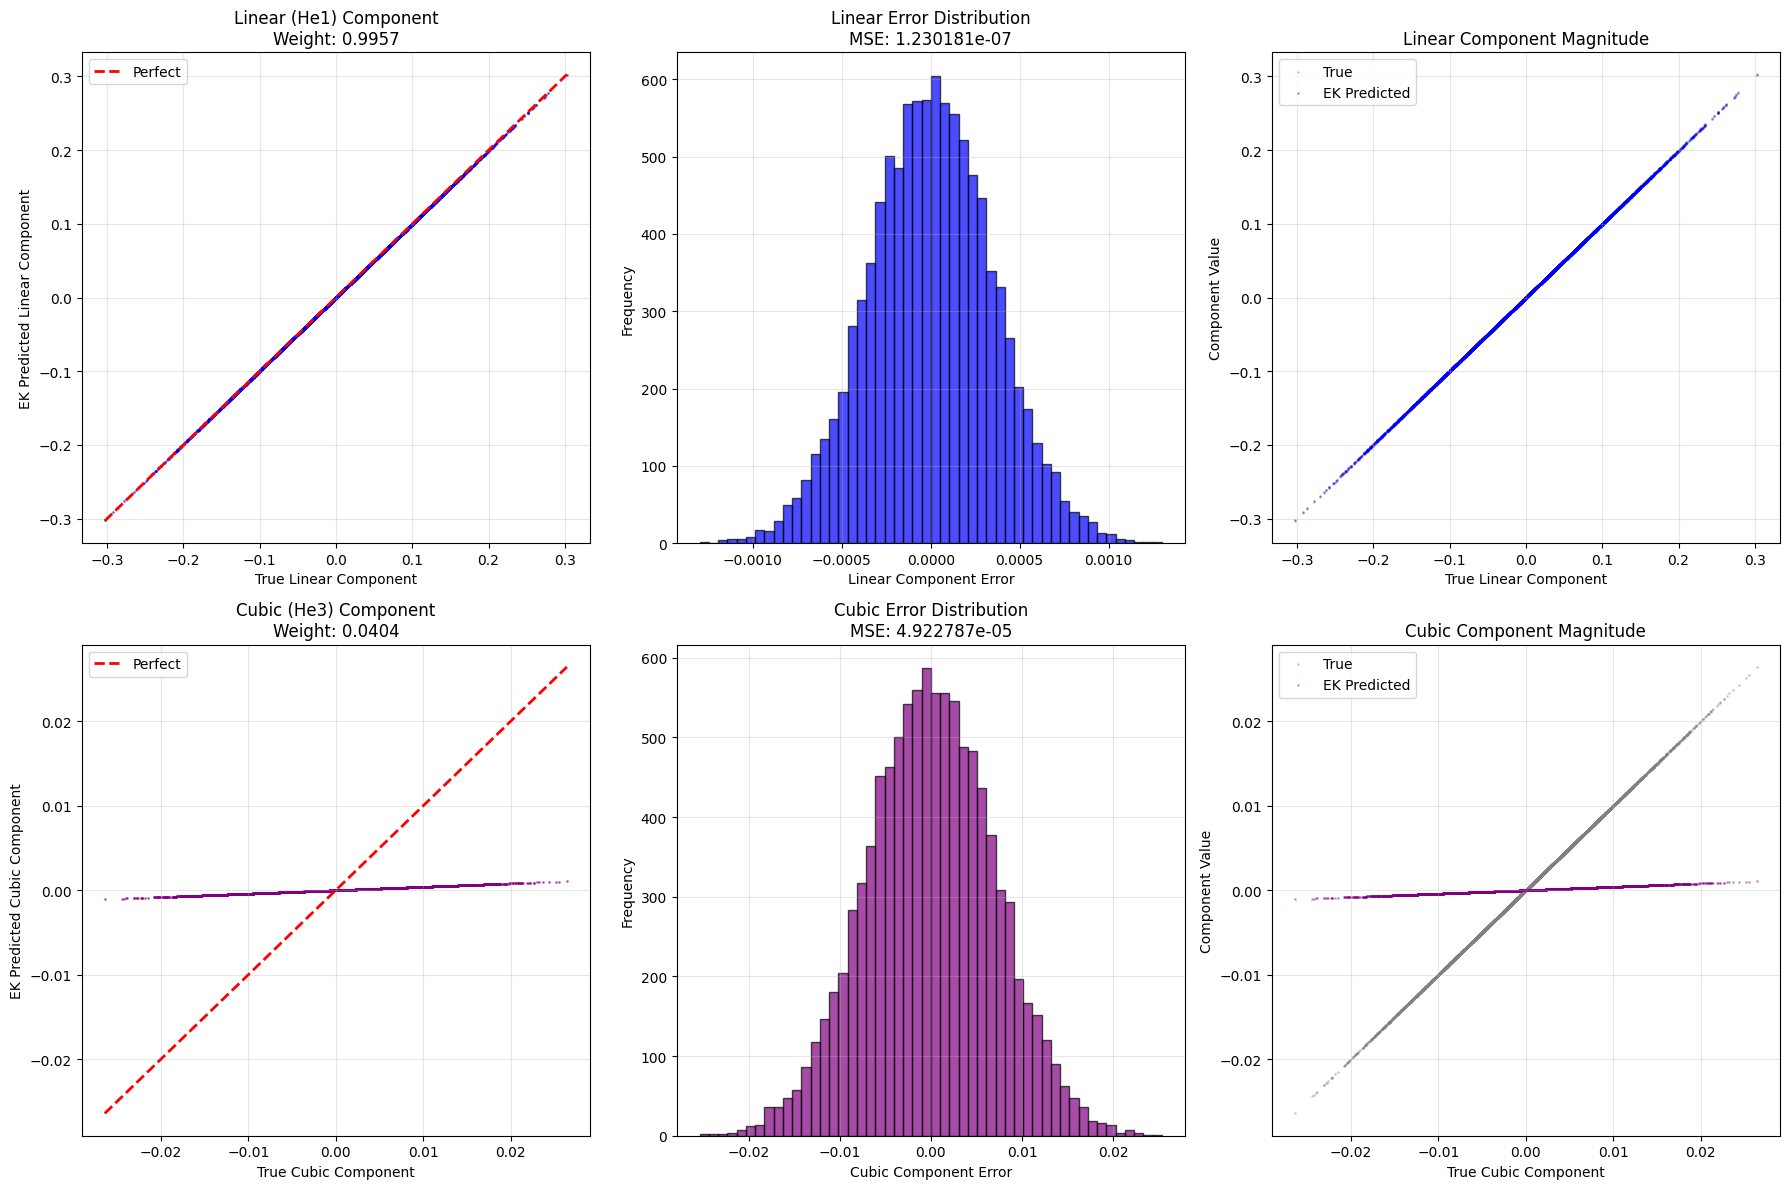

Linear Component Statistics:
  True coefficient: 1.0000
  Ridge weight: 0.9957
  Effective coefficient: 0.9957
  MSE: 1.230181e-07
  MAE: 2.795021e-04

Cubic Component Statistics:


AttributeError: 'float' object has no attribute 'item'

In [41]:
# Plot linear and cubic components separately
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Linear component (He1)
# Subplot 1: Linear component prediction vs true
axes[0, 0].scatter(y_true_linear.cpu(), y_pred_ek_linear.cpu(), alpha=0.5, s=1, color='blue')
axes[0, 0].plot([y_true_linear.min().cpu(), y_true_linear.max().cpu()], 
                [y_true_linear.min().cpu(), y_true_linear.max().cpu()], 'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('True Linear Component')
axes[0, 0].set_ylabel('EK Predicted Linear Component')
axes[0, 0].set_title(f'Linear (He1) Component\nWeight: {weight_H1T:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Linear component error distribution
linear_errors = (y_pred_ek_linear - y_true_linear).cpu()
axes[0, 1].hist(linear_errors, bins=50, alpha=0.7, edgecolor='black', color='blue')
axes[0, 1].set_xlabel('Linear Component Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Linear Error Distribution\nMSE: {(linear_errors**2).mean():.6e}')
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Linear component magnitude comparison
axes[0, 2].scatter(y_true_linear.cpu(), y_true_linear.cpu(), alpha=0.3, s=1, color='gray', label='True')
axes[0, 2].scatter(y_true_linear.cpu(), y_pred_ek_linear.cpu(), alpha=0.3, s=1, color='blue', label='EK Predicted')
axes[0, 2].set_xlabel('True Linear Component')
axes[0, 2].set_ylabel('Component Value')
axes[0, 2].set_title('Linear Component Magnitude')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Cubic component (He3)
# Subplot 4: Cubic component prediction vs true
axes[1, 0].scatter(y_true_cubic.cpu(), y_pred_ek_cubic.cpu(), alpha=0.5, s=1, color='purple')
axes[1, 0].plot([y_true_cubic.min().cpu(), y_true_cubic.max().cpu()], 
                [y_true_cubic.min().cpu(), y_true_cubic.max().cpu()], 'r--', lw=2, label='Perfect')
axes[1, 0].set_xlabel('True Cubic Component')
axes[1, 0].set_ylabel('EK Predicted Cubic Component')
axes[1, 0].set_title(f'Cubic (He3) Component\nWeight: {weight_H3T:.4f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Subplot 5: Cubic component error distribution
cubic_errors = (y_pred_ek_cubic - y_true_cubic).cpu()
axes[1, 1].hist(cubic_errors, bins=50, alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].set_xlabel('Cubic Component Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Cubic Error Distribution\nMSE: {(cubic_errors**2).mean():.6e}')
axes[1, 1].grid(True, alpha=0.3)

# Subplot 6: Cubic component magnitude comparison
axes[1, 2].scatter(y_true_cubic.cpu(), y_true_cubic.cpu(), alpha=0.3, s=1, color='gray', label='True')
axes[1, 2].scatter(y_true_cubic.cpu(), y_pred_ek_cubic.cpu(), alpha=0.3, s=1, color='purple', label='EK Predicted')
axes[1, 2].set_xlabel('True Cubic Component')
axes[1, 2].set_ylabel('Component Value')
axes[1, 2].set_title('Cubic Component Magnitude')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print component statistics
print(f"Linear Component Statistics:")
print(f"  True coefficient: {true_coef_H1:.4f}")
print(f"  Ridge weight: {weight_H1T:.4f}")
print(f"  Effective coefficient: {true_coef_H1 * weight_H1T:.4f}")
print(f"  MSE: {(linear_errors**2).mean():.6e}")
print(f"  MAE: {linear_errors.abs().mean():.6e}")

print(f"\nCubic Component Statistics:")
print(f"  True coefficient: {true_coef_H3.item():.6f}")
print(f"  Ridge weight: {weight_H3T:.4f}")
print(f"  Effective coefficient: {(true_coef_H3 * weight_H3T).item():.6f}")
print(f"  MSE: {(cubic_errors**2).mean():.6e}")
print(f"  MAE: {cubic_errors.abs().mean():.6e}")

print(f"\nComponent Contribution to Total Prediction:")
print(f"  Linear component variance: {y_pred_ek_linear.var().item():.6e}")
print(f"  Cubic component variance: {y_pred_ek_cubic.var().item():.6e}")
print(f"  Ratio (Linear/Cubic): {(y_pred_ek_linear.var() / y_pred_ek_cubic.var()).item():.2f}")


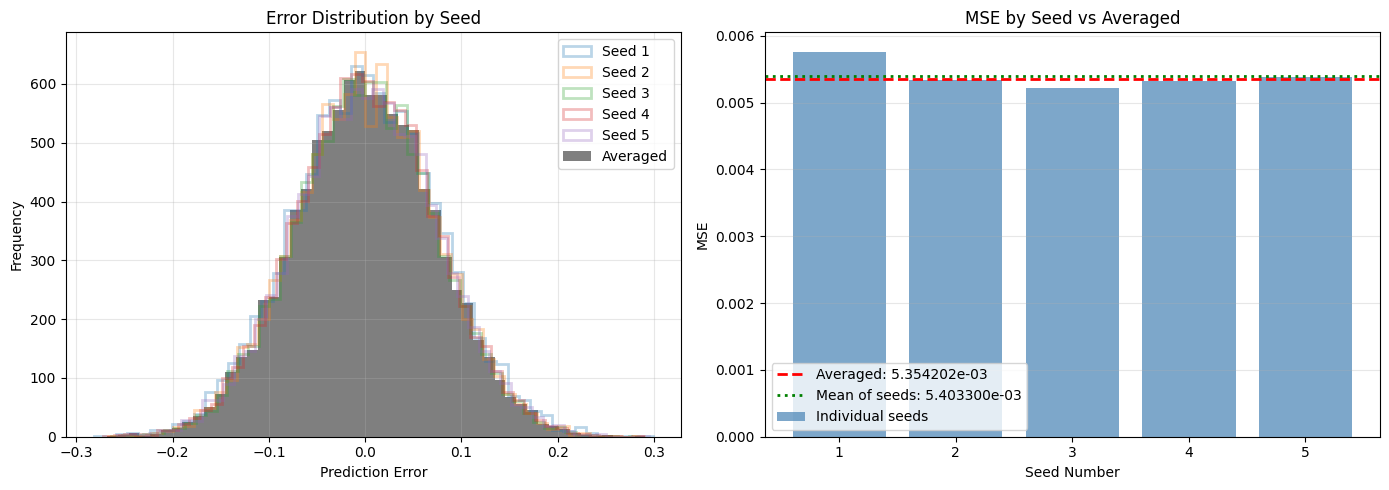

Individual Seed MSE Statistics:
  Mean: 5.403300e-03
  Std: 1.888055e-04
  Min: 5.215523e-03 (Seed 3)
  Max: 5.764060e-03 (Seed 1)

Averaged Model MSE: 5.354202e-03
Improvement: 0.91%


In [ ]:
# Analyze variance across seeds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Distribution of predictions from each seed
for i, y_pred in enumerate(all_predictions):
    errors = (y_pred - y_true).cpu()
    axes[0].hist(errors, bins=50, alpha=0.3, label=f'Seed {i+1}', histtype='step', linewidth=2)

# Add averaged predictions
axes[0].hist(errors_model, bins=50, alpha=0.5, label='Averaged', color='black', linewidth=3)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution by Seed')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: MSE comparison across seeds
seed_mses = [(pred - y_true).pow(2).mean().item() for pred in all_predictions]
avg_mse = (y_pred_model - y_true).pow(2).mean().item()

x_pos = list(range(1, len(seed_mses) + 1))
axes[1].bar(x_pos, seed_mses, alpha=0.7, color='steelblue', label='Individual seeds')
axes[1].axhline(y=avg_mse, color='red', linestyle='--', linewidth=2, label=f'Averaged: {avg_mse:.6e}')
axes[1].axhline(y=np.mean(seed_mses), color='green', linestyle=':', linewidth=2, label=f'Mean of seeds: {np.mean(seed_mses):.6e}')
axes[1].set_xlabel('Seed Number')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE by Seed vs Averaged')
axes[1].set_xticks(x_pos)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Individual Seed MSE Statistics:")
print(f"  Mean: {np.mean(seed_mses):.6e}")
print(f"  Std: {np.std(seed_mses):.6e}")
print(f"  Min: {np.min(seed_mses):.6e} (Seed {np.argmin(seed_mses) + 1})")
print(f"  Max: {np.max(seed_mses):.6e} (Seed {np.argmax(seed_mses) + 1})")
print(f"\nAveraged Model MSE: {avg_mse:.6e}")
print(f"Improvement: {(np.mean(seed_mses) - avg_mse) / np.mean(seed_mses) * 100:.2f}%")


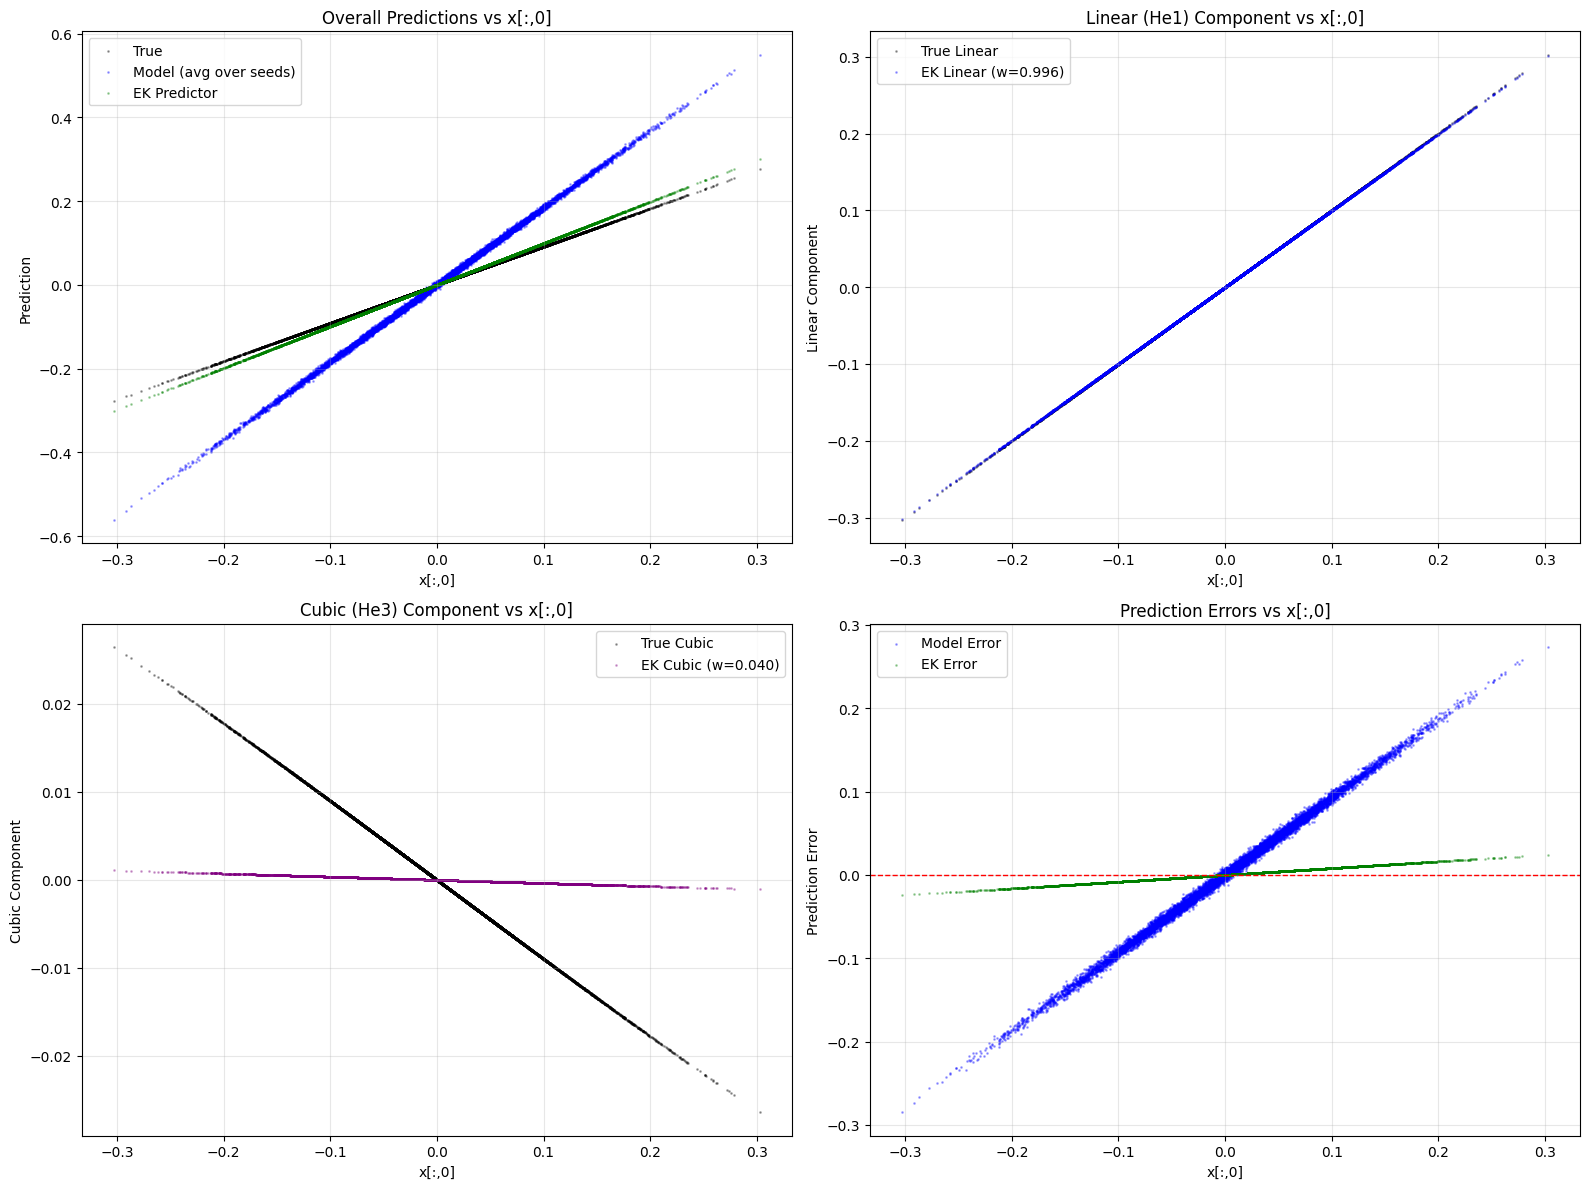

Functional structure analysis:
x[:,0] range: [-0.3030, 0.3027]
True function shows linear + small cubic structure
Linear component dominates due to coefficient 1.00 vs 0.0300


In [42]:
# Plot predictions as a function of x[:,0] to visualize functional structure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get x0 values and sort indices for smooth plotting
x0 = X_test[:, 0].cpu()
sort_idx = torch.argsort(x0)
x0_sorted = x0[sort_idx]

# Sort all predictions and true values
y_true_sorted = y_true[sort_idx].cpu()
y_pred_model_sorted = y_pred_model[sort_idx].cpu()
y_pred_ek_sorted = y_pred_ek[sort_idx].cpu()
y_pred_ek_linear_sorted = y_pred_ek_linear[sort_idx].cpu()
y_pred_ek_cubic_sorted = y_pred_ek_cubic[sort_idx].cpu()
y_true_linear_sorted = y_true_linear[sort_idx].cpu()
y_true_cubic_sorted = y_true_cubic[sort_idx].cpu()

# Subplot 1: Overall predictions vs x0
axes[0, 0].scatter(x0_sorted, y_true_sorted, s=1, alpha=0.3, color='black', label='True')
axes[0, 0].scatter(x0_sorted, y_pred_model_sorted, s=1, alpha=0.3, color='blue', label='Model (avg over seeds)')
axes[0, 0].scatter(x0_sorted, y_pred_ek_sorted, s=1, alpha=0.3, color='green', label='EK Predictor')
axes[0, 0].set_xlabel('x[:,0]')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].set_title('Overall Predictions vs x[:,0]')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Linear component vs x0
axes[0, 1].scatter(x0_sorted, y_true_linear_sorted, s=1, alpha=0.3, color='black', label='True Linear')
axes[0, 1].scatter(x0_sorted, y_pred_ek_linear_sorted, s=1, alpha=0.3, color='blue', label=f'EK Linear (w={weight_H1T:.3f})')
axes[0, 1].set_xlabel('x[:,0]')
axes[0, 1].set_ylabel('Linear Component')
axes[0, 1].set_title('Linear (He1) Component vs x[:,0]')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Cubic component vs x0
axes[1, 0].scatter(x0_sorted, y_true_cubic_sorted, s=1, alpha=0.3, color='black', label='True Cubic')
axes[1, 0].scatter(x0_sorted, y_pred_ek_cubic_sorted, s=1, alpha=0.3, color='purple', label=f'EK Cubic (w={weight_H3T:.3f})')
axes[1, 0].set_xlabel('x[:,0]')
axes[1, 0].set_ylabel('Cubic Component')
axes[1, 0].set_title('Cubic (He3) Component vs x[:,0]')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: Prediction errors vs x0
model_errors_sorted = (y_pred_model_sorted - y_true_sorted)
ek_errors_sorted = (y_pred_ek_sorted - y_true_sorted)

axes[1, 1].scatter(x0_sorted, model_errors_sorted, s=1, alpha=0.3, color='blue', label='Model Error')
axes[1, 1].scatter(x0_sorted, ek_errors_sorted, s=1, alpha=0.3, color='green', label='EK Error')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('x[:,0]')
axes[1, 1].set_ylabel('Prediction Error')
axes[1, 1].set_title('Prediction Errors vs x[:,0]')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Functional structure analysis:")
print(f"x[:,0] range: [{x0.min():.4f}, {x0.max():.4f}]")
print(f"True function shows linear + small cubic structure")
print(f"Linear component dominates due to coefficient {true_coef_H1:.2f} vs {true_coef_H3:.4f}")


/tmp/ipykernel_325490/3950163182.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  bin_stds.append(y[mask].std())


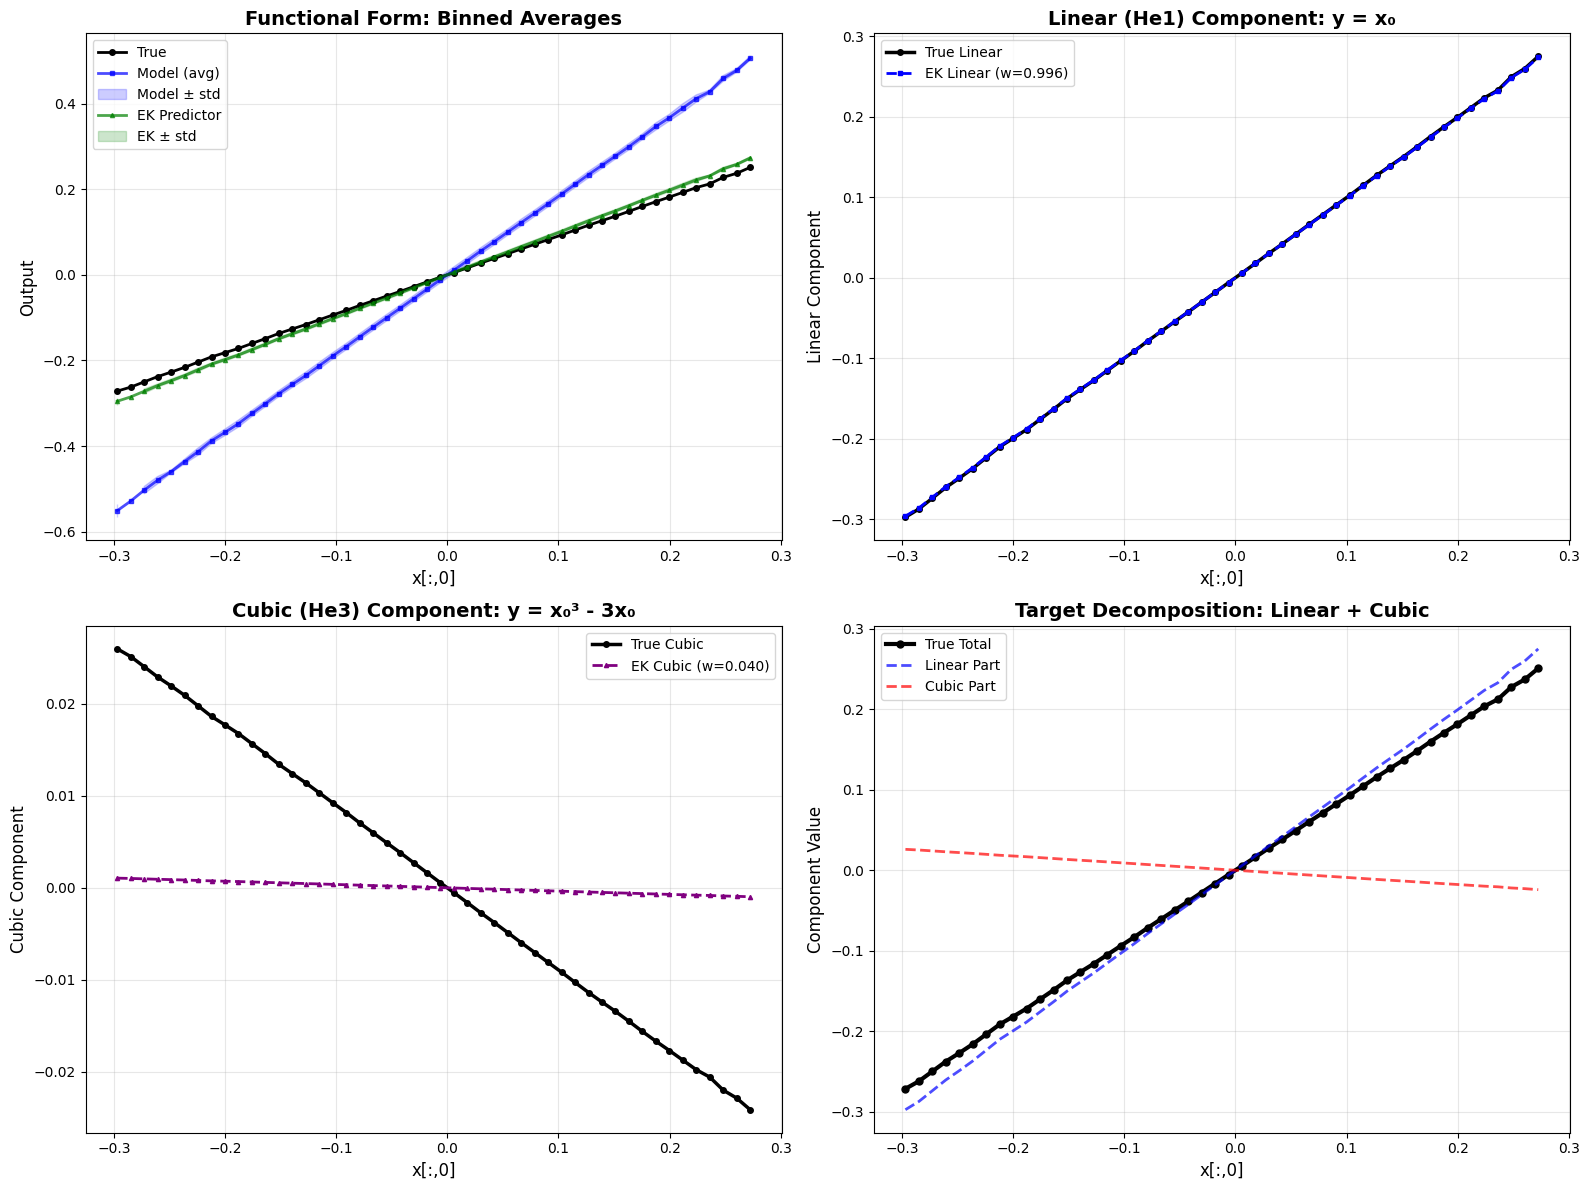

Binned prediction quality:
  Model MSE (binned): 2.448743e-02
  EK MSE (binned): 1.840073e-04
  Linear component MSE: 5.209747e-07
  Cubic component MSE: 2.041094e-04


In [44]:
# Create binned plot to see smooth functional form
n_bins = 50
x0 = X_test[:, 0].cpu()

# Create bins
bin_edges = np.linspace(x0.min(), x0.max(), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Function to compute binned statistics
def bin_data(x, y, bins):
    bin_means = []
    bin_stds = []
    for i in range(len(bins) - 1):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(y[mask].mean())
            bin_stds.append(y[mask].std())
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)
    return np.array(bin_means), np.array(bin_stds)

# Compute binned statistics
y_true_binned, _ = bin_data(x0, y_true.cpu(), bin_edges)
y_model_binned, y_model_std = bin_data(x0, y_pred_model.cpu(), bin_edges)
y_ek_binned, y_ek_std = bin_data(x0, y_pred_ek.cpu(), bin_edges)
y_linear_true_binned, _ = bin_data(x0, y_true_linear.cpu(), bin_edges)
y_linear_ek_binned, _ = bin_data(x0, y_pred_ek_linear.cpu(), bin_edges)
y_cubic_true_binned, _ = bin_data(x0, y_true_cubic.cpu(), bin_edges)
y_cubic_ek_binned, _ = bin_data(x0, y_pred_ek_cubic.cpu(), bin_edges)

# Create smooth functional plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Overall function
axes[0, 0].plot(bin_centers, y_true_binned, 'k-', linewidth=2, label='True', marker='o', markersize=4)
axes[0, 0].plot(bin_centers, y_model_binned, 'b-', linewidth=2, label='Model (avg)', marker='s', markersize=3, alpha=0.7)
axes[0, 0].fill_between(bin_centers, y_model_binned - y_model_std, y_model_binned + y_model_std, 
                         alpha=0.2, color='blue', label='Model ± std')
axes[0, 0].plot(bin_centers, y_ek_binned, 'g-', linewidth=2, label='EK Predictor', marker='^', markersize=3, alpha=0.7)
axes[0, 0].fill_between(bin_centers, y_ek_binned - y_ek_std, y_ek_binned + y_ek_std, 
                         alpha=0.2, color='green', label='EK ± std')
axes[0, 0].set_xlabel('x[:,0]', fontsize=12)
axes[0, 0].set_ylabel('Output', fontsize=12)
axes[0, 0].set_title('Functional Form: Binned Averages', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Linear component
axes[0, 1].plot(bin_centers, y_linear_true_binned, 'k-', linewidth=2.5, label='True Linear', marker='o', markersize=4)
axes[0, 1].plot(bin_centers, y_linear_ek_binned, 'b--', linewidth=2, label=f'EK Linear (w={weight_H1T:.3f})', marker='s', markersize=3)
axes[0, 1].set_xlabel('x[:,0]', fontsize=12)
axes[0, 1].set_ylabel('Linear Component', fontsize=12)
axes[0, 1].set_title('Linear (He1) Component: y = x₀', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Cubic component
axes[1, 0].plot(bin_centers, y_cubic_true_binned, 'k-', linewidth=2.5, label='True Cubic', marker='o', markersize=4)
axes[1, 0].plot(bin_centers, y_cubic_ek_binned, 'purple', linestyle='--', linewidth=2, 
                label=f'EK Cubic (w={weight_H3T:.3f})', marker='^', markersize=3)
axes[1, 0].set_xlabel('x[:,0]', fontsize=12)
axes[1, 0].set_ylabel('Cubic Component', fontsize=12)
axes[1, 0].set_title('Cubic (He3) Component: y = x₀³ - 3x₀', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: Component decomposition
axes[1, 1].plot(bin_centers, y_true_binned, 'k-', linewidth=3, label='True Total', marker='o', markersize=5)
axes[1, 1].plot(bin_centers, y_linear_true_binned, 'b--', linewidth=2, label='Linear Part', alpha=0.7)
axes[1, 1].plot(bin_centers, y_cubic_true_binned, 'r--', linewidth=2, label='Cubic Part', alpha=0.7)
axes[1, 1].set_xlabel('x[:,0]', fontsize=12)
axes[1, 1].set_ylabel('Component Value', fontsize=12)
axes[1, 1].set_title('Target Decomposition: Linear + Cubic', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("Binned prediction quality:")
print(f"  Model MSE (binned): {np.nanmean((y_model_binned - y_true_binned)**2):.6e}")
print(f"  EK MSE (binned): {np.nanmean((y_ek_binned - y_true_binned)**2):.6e}")
print(f"  Linear component MSE: {np.nanmean((y_linear_ek_binned - y_linear_true_binned)**2):.6e}")
print(f"  Cubic component MSE: {np.nanmean((y_cubic_ek_binned - y_cubic_true_binned)**2):.6e}")
